In [1]:
!pip install -q swig
!pip install -q gymnasium[box2d]
!pip install keras-rl2

In [2]:
import gymnasium as gym
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
from keras import __version__
tf.keras.__version__ = __version__
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy
import random
import numpy as np
from collections import deque

In [3]:
env = gym.make("LunarLander-v2", render_mode="human")

observation, info = env.reset(seed=42)
size_action_space = env.action_space.n

In [4]:
neuros_each_layer = 12
activation_func = "relu"

# Construção da arquitetura da principal rede neural
def build_network():
  model = Sequential()
  model.add(Flatten(input_shape=(1, len(observation))))
  model.add(Dense(neuros_each_layer, activation=activation_func))
  model.add(Dense(neuros_each_layer, activation=activation_func))
  model.add(Dense(neuros_each_layer, activation=activation_func))
  model.add(Dense(size_action_space, activation="softmax"))
  return model

# Construção da arquitetura para rede neural target
def build_target_network():
  model = Sequential()
  model.add(Flatten(input_shape=(1, len(observation))))
  model.add(Dense(neuros_each_layer, activation=activation_func))
  model.add(Dense(neuros_each_layer, activation=activation_func))
  model.add(Dense(neuros_each_layer, activation=activation_func))
  model.add(Dense(size_action_space, activation="softmax"))
  return model


In [5]:
import matplotlib.pyplot as plt

class AgentDQN:
    def __init__(self, action_length, state_length):
        """
        Inicializa um agente de aprendizado por reforço com DQN.

        Parâmetros:
            action_length (int): O tamanho do espaço de ação.
            state_length (int): O tamanho do espaço de estado.
        """
        # Tamanho do espaço de ação
        self.action_length = action_length
        # Tamanho do espaço de estado
        self.state_length = state_length
        # Taxa de aprendizado
        self.learning_rate = 0.05
        # Fator de desconto
        self.gamma = 0.99
        # Armazena experiências anteriores para treinamento
        self.all_data = deque(maxlen=10000)
        # Valor inicial de epsilon para a política epsilon-greedy
        self.epsilon = 1
        # Valor mínimo de epsilon para exploração
        self.epsilon_min = 0.01
        # Taxa de decaimento de epsilon
        self.epsilon_decay = 0.995
        # Política de exploração: Epsilon-greedy
        self.policy = EpsGreedyQPolicy(self.epsilon)
        # Rede neural principal
        self.network = build_network()
        # Rede neural alvo (para atualização periódica)
        self.target_network = build_target_network()
        # Tamanho do lote de dados para treinamento
        self.length_batch_for_train = 30
        # Otimizador para treinamento da rede
        self.optimizer = Adam(learning_rate=self.learning_rate)
        # Lista para armazenar as recompensas acumuladas por episódio
        self.rewards_per_episode = []

    def q_learning(self):
        """
        Método para realizar o treinamento do agente usando o algoritmo de Q-Learning.
        """
        if len(self.all_data) < self.length_batch_for_train:
            return

        # Amostra um lote de experiências
        mini_batch = random.sample(self.all_data, self.length_batch_for_train)
        states, targets = [], []
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_network.predict(next_state)[0])
            target_f = self.network.predict(state)
            target_f[0][action] = target
            states.append(state)
            targets.append(target_f)

        # Treina a rede com o lote de dados amostrado
        states = np.array(states).reshape(-1, 1, self.state_length)
        targets = np.array(targets).reshape(-1, self.action_length)

        # Calcula gradientes
        with tf.GradientTape() as tape:
            q_values = self.network(states, training=True)
            loss = tf.keras.losses.mean_squared_error(targets, q_values)

        # Obtém gradientes
        grads = tape.gradient(loss, self.network.trainable_variables)

        # Atualiza pesos do modelo
        self.optimizer.apply_gradients(zip(grads, self.network.trainable_variables))

    def experience(self, state, action, reward, next_state, done):
        """
        Método para armazenar experiências de transição.

        Parâmetros:
            state (array): Estado atual.
            action (int): Ação tomada pelo agente.
            reward (float): Recompensa recebida após a ação.
            next_state (array): Próximo estado após a ação.
            done (bool): Indica se o episódio terminou.
        """
        self.all_data.append((state, action, reward, next_state, done))

    def train(self, episodes=20):
        """
        Método para treinar o agente.

        Parâmetros:
            episodes (int): Número de episódios para treinamento (padrão: 20).
        """
        # Treinamento do agente
        for episode in range(1, episodes + 1):
            total_reward = 0
            state = env.reset()
            state = np.reshape(state[0], [1, 1, self.state_length])  # Adiciona a dimensão de tempo

            for time_step in range(30):
                q_values = self.network.predict(state)[0]
                action = self.policy.select_action(q_values)
                step_result = env.step(action)
                next_state, reward, done, _ = step_result[:4]
                next_state = np.reshape(next_state, [1, 1, self.state_length])  # Adiciona a dimensão de tempo
                self.experience(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                print("Step:", time_step, " Reward:", reward)  # Print de desempenho de cada etapa
                if done:
                    break
                if len(self.all_data) > self.length_batch_for_train:
                    self.q_learning()

            self.rewards_per_episode.append(total_reward)

            # Atualiza a rede alvo após cada episódio
            self.target_network.set_weights(self.network.get_weights())

            print("Episode:", episode, " Total Reward:", total_reward)

    def plot_rewards(self):
        """
        Método para plotar as recompensas acumuladas por episódio.
        """
        plt.plot(self.rewards_per_episode)
        plt.xlabel('Episódio')
        plt.ylabel('Recompensa Acumulada')
        plt.title('Recompensas Acumuladas por Episódio')
        plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Step: 0  Reward: -1.4359782430063308
Step: 1  Reward: -1.8823423231084166
Step: 2  Reward: -0.808668612310953
Step: 3  Reward: 0.3809920053093674
Step: 4  Reward: -0.7118832653187326
Step: 5  Reward: -0.778144359257368
Step: 6  Reward: -1.0217489282176075
Step: 7  Reward: -2.1462443905688233
Step: 8  Reward: -1.1028302756119501
Step: 9  Reward: -2.671133864565688
Step: 10  Reward: -2.0071583149071612
Step: 11  Reward: -0.12022683954449917
Step: 12  Reward: -2.4420936619609948
Step: 13  Reward: -0.5974975443318715
Step: 14  Reward: -1.4271595202741594
Step: 15  Reward: -0.18589802956367293
Step: 16  Reward: -1.7716596576501502
Step: 17  Reward: -0.24101320268314794
Step: 18  Reward: -1.1505565426303122
Step: 19  Reward: -1.2038426651565999
Step: 20  Reward: -0.27872098228541975
Step: 21  Reward: -1.1309473022343468
Step: 22  Reward: -2.251398542258214
Step: 23  Reward: -0.1226936767666291
Step: 24  Reward: -1.2114912427470301
Step: 25  Reward: -1.7925632455505707
Step: 26  Reward: -1.09

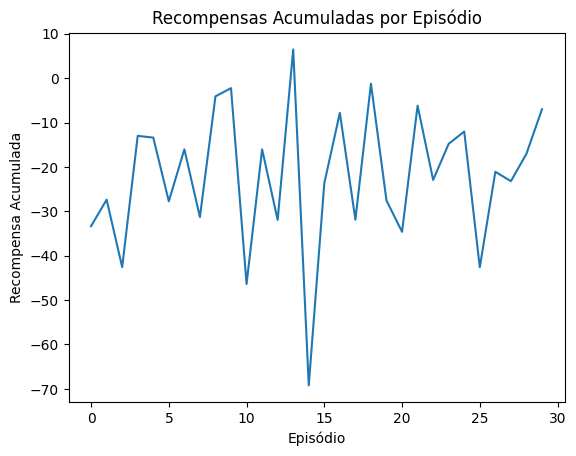

In [6]:
agent = AgentDQN(size_action_space, observation.shape[0])
agent.train(episodes=30)

agent.plot_rewards()
